# Programa para leer la placa de una imagen (enfocado en placas de fondo blanco)

En primer lugar se importan todos los paquetes y módulos necesarios. Se especifica la ruta en donde se encuentra instalado Easy OCR.

In [1]:
import cv2
import matplotlib.pyplot as plt
from third_test import test_plate_method3
from plate_reader import read_plate
import skimage
import numpy as np
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

Se lee la imagen y se plotea en RGB


*********
Image: 1


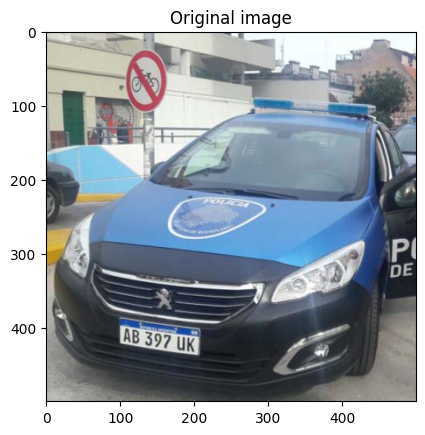

In [2]:
image = 1
print(f"\n*********\nImage: {image}")
img = cv2.imread(f'plates/{image:03}.png', cv2.IMREAD_COLOR)
plt.title("Original image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Se halla la zona de la placa usando el [algoritmo número 3](test3.ipynb) enfocado en placas de fondo blanco y se muestra la imagen de la zona detectada.

*****************
Found plate: [ True]
*****************



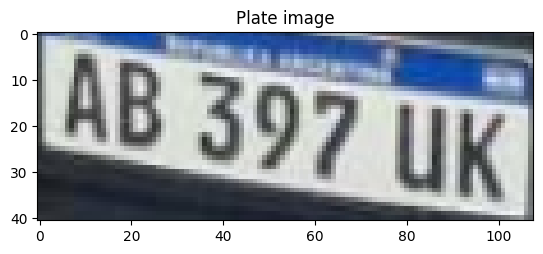

In [3]:
b, plate, m = test_plate_method3(img)
print(f"*****************\nFound plate: {b}\n*****************\n")

plt.title("Plate image")
plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
plt.show()

Se crea una lista de listas en donde se guardarán los diferentes resultados para los caracteres de las placas argentinas. Este tipo de placas cuenta con 7 caracteres. Los primeros y últimos dos caracteres corresponden a letras. Los 3 de la mitad corresponden a números. Se especifican los índices de acuerdo a este orden.

In [4]:
characters = [[], [], [], [], [], [], []]
num_index = [2, 3, 4]
letter_index = [0, 1, 5, 6]

Se llama a la función *read_plate* para hallar los caracteres de la placa mediante la segmentación de la imagen en cada uno de los caracteres presentes usando métodos de procesamiento de imagen tradicional junto al uso de Easy OCR.

Number of characters in plate before filter: 7
Number of characters in plate after filter: 7


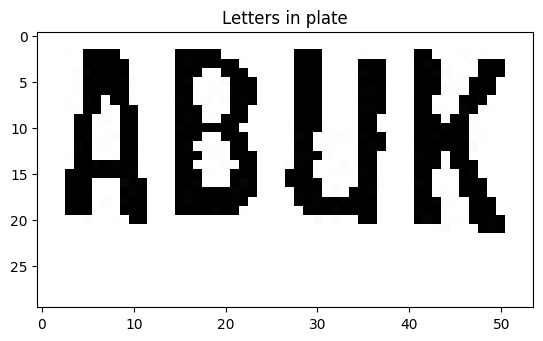

Detected letters: ABUK



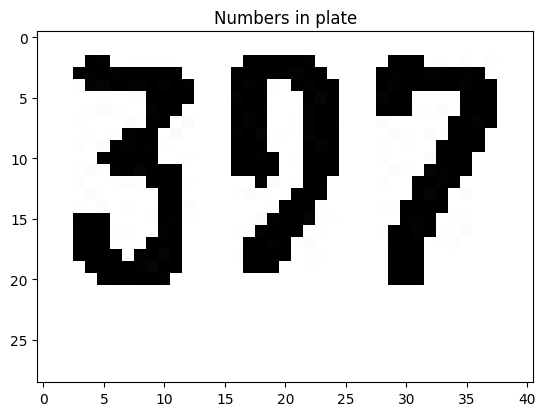

Detected numbers: 597

Detected plate with character segmentation: AB597UK


In [5]:
letters_0, numbers_0 = read_plate(plate)
print(f"Detected plate with character segmentation: {letters_0[:2] + numbers_0 + letters_0[2:]}")

Se añaden los resultados obtenidos por la función *read_plate* a la lista de caracteres previamente creada.

In [6]:
for num, index in zip(numbers_0, num_index):
    characters[index].append(num)

for letter, index in zip(letters_0, letter_index):
    characters[index].append(letter)

Se procede ahora a leer los caracteres de la placa directamente usando la imagen obtenida mediante el algoritmo 3 de detección de placas.

In [7]:
psm = 7
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
options += " --psm {}".format(psm)

text = pytesseract.image_to_string(plate, config=options).replace(" ", "").strip()
print(f"Detected plate with original image: {text}")

Detected plate with original image: AB397UK


Se verifica que el string retornado tenga una longitud de 7 caracteres y se añaden a la lista de caracteres verificando si sí corresponden a números o letras dependiendo de la posición en la placa.

In [8]:
if len(text) == 7:
    letters_1 = [text[0], text[1], text[5], text[6]]
    numbers_1 = [text[2], text[3], text[4]]

    for num, index in zip(numbers_1, num_index):
        if num.isdigit():
            characters[index].append(num)
    
    for letter, index in zip(letters_1, letter_index):
        if letter.isalpha():
            characters[index].append(letter)

Se procede ahora a leer los caracteres de la placa usando una imagen procesada a partir de la imagen obtenida directamente del algoritmo 3 de detección de placas. Este procesamiento consiste en convertir la imagen a escala de grises, aplicar una umbralización y limpiar los bordes de la imagen.

In [9]:
plate_gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

thres = cv2.adaptiveThreshold(plate_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 13)
clear_border = skimage.segmentation.clear_border(thres)

inverted = cv2.bitwise_not(clear_border)

text = pytesseract.image_to_string(inverted, config=options).replace(" ", "").strip()
print(f"Detected plate with processed image: {text}")

Detected plate with processed image: AB397UK


Se verifica para el string retornado si tiene 7 caracteres y se añaden a la lista de caracteres previa verificación de que sean dígitos o letras según corresponda a la posición de la placa.

In [10]:
if len(text) == 7:
    letters_1 = [text[0], text[1], text[5], text[6]]
    numbers_1 = [text[2], text[3], text[4]]

    for num, index in zip(numbers_1, num_index):
        if num.isdigit():
            characters[index].append(num)
    
    for letter, index in zip(letters_1, letter_index):
        if letter.isalpha():
            characters[index].append(letter)

Se crea un diccionario en donde la llave corresponde al caracter y el valor corresponde al número de veces que aparece. Se crea posteriormente una lista con los elementos del diccionario ordenados de mayor a menor en número de apariciones.

In [11]:
d = []
for chars in characters:
    d.append({x:chars.count(x) for x in chars})

sorted_d = []
for di in d:
    sorted_d.append(sorted(di.items(), key= lambda x:x[1], reverse=True))

Se determina los caracteres correspondientes a cada una de las posiciones de la placa junto a una evluación cualitativa de la certeza que se tiene teniendo en cuenta los 3 resultados posibles.

* Sure: Los 3 resultados retornaron el mismo caracter
* Almost sure: Sólo 2 resultados retornaron caracter pero se trata del mismo caracter
* Almost sure but it also could be... : 2 de los 3 resultados retornaron el mismo caracter. Se muestra la alternativa presentada por el otro resultado.
* Not sure. Possible options: Todos los resultados retornaron caracteres distintos. Se muestran las posibles opciones.

In [12]:
print("\nPLATE CHARACTERS")

for i, option in enumerate(sorted_d):
    print(f"Character {i+1}:", end=" ")
    if len(option) == 1 and option[0][1] == 3:
        print(f"{option[0][0]} Sure")
    elif len(option) == 1 and option[0][1] == 2:
        print(f"{option[0][0]} Almost sure")
    elif len(option) == 2 and option[0][1] == 2:
        print(f"{option[0][0]} Almost sure but it also could be {option[1][0]}")
    else:
        print("Not sure. Possible options:", end=" ")
        for charac in option:
            print(charac[0], end=" ")
        print()


PLATE CHARACTERS
Character 1: A Sure
Character 2: B Sure
Character 3: 3 Almost sure but it also could be 5
Character 4: 9 Sure
Character 5: 7 Sure
Character 6: U Sure
Character 7: K Sure
